<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Функция-для-поиска-лучшей-модели" data-toc-modified-id="Функция-для-поиска-лучшей-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Функция для поиска лучшей модели</a></span></li><li><span><a href="#Модель-дерева" data-toc-modified-id="Модель-дерева-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель дерева</a></span></li><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [75]:
import pandas as pd 
import numpy as np 
import nltk
import re

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer
) 

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
) 

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [76]:
try:
    data = pd.read_csv('/Users/a1/Documents/DataScientist/DataSets/toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [78]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [79]:
data.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


В данных пристуствуют пробелы, символы и прочий "муссор" от которого нужно избавится.

In [80]:
data.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Удалим не информативный столбец 'Unnamed: 0':

In [81]:
data = data.drop(['Unnamed: 0'], axis=1)

<AxesSubplot:>

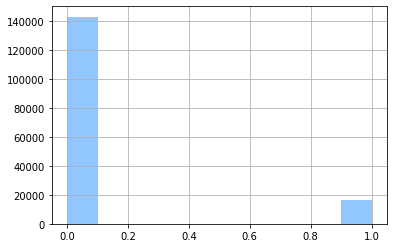

In [82]:
data["toxic"].hist()

Кол-во 0 и 1 в целевом признаке разное. 1 в разы меньше.

Создадим функцию которая будет приводить текст к нижнему регистру

In [83]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text.lower())
    retext = text.split() 
    text = " ".join(retext)
    return text

Создадим функцию, которая будет токенизировать и лемматезировать текст

In [84]:
def lemmetize(words):
    lemmatizer = WordNetLemmatizer()
    # список для заполнения
    text = [] 
    # токенизация
    tokens = word_tokenize(words)
    # лемматизация
    for token in tokens: 
        lemmetized_word = lemmatizer.lemmatize(token) 
        text.append(lemmetized_word)
    # объединение   
    sentence = " ".join(text) 
    return sentence

Загрузим список стоп-слов:

In [85]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [86]:
stopwords = set(nltk_stopwords.words('english'))

In [87]:
len(stopwords)

179

Обработка исходных данных:

Создаим кпоию данных и применим созданные ранее функции

In [88]:
data_lem = data.copy()

In [89]:
data_lem['lemm_text'] = data_lem['text'].apply(clear_text)
data_lem['lemm_text'] = data_lem['lemm_text'].apply(lemmetize)

In [90]:
# check
data_lem['lemm_text']

0         explanation why the edits made under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestion on impro...
4         you sir are my hero any chance you remember wh...
                                ...                        
159287    and for the second time of asking when your vi...
159288    you should be ashamed of yourself that is a ho...
159289    spitzer umm there no actual article for prosti...
159290    and it look like it wa actually you who put on...
159291    and i really don t think you understand i came...
Name: lemm_text, Length: 159292, dtype: object

Выделим целевой признак и признаки

In [98]:
features = data_lem.drop('toxic', axis=1)
train = data_lem['toxic']

Разделим выборки

In [101]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    train,
    test_size=0.2,
    random_state=12345,
    stratify=train
)

Создадим корпусы

In [102]:
corpus_train = features_train['lemm_text']
corpus_test = features_test['lemm_text']

In [103]:
#check
corpus_train

4627      i don t mean to intrude but i have noticed the...
23542     god or whoever whatever i now decree you the c...
128384    can we keep this neat and sequential we have a...
31111     here s what you said may rama blocked expires ...
41207     sir giggsy ha often said that he like to keep ...
                                ...                        
54715     indeed bigdunc that page rightly say that para...
75564     i m not trying to make a point or anything exc...
71196     forgive my cruddy formattingi m still relative...
55751     talk grasshopper scout i moved your comment fr...
11543                                  oppose wp commonname
Name: lemm_text, Length: 127433, dtype: object

При создании счётчика передадим список стоп-слов в счётчик векторов 

In [104]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform():

In [105]:
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

In [106]:
#check
print("Размер тренировочной матрицы:", tf_idf_train.shape)
print("Размер тестовой матрицы:", tf_idf_test.shape)

Размер тренировочной матрицы: (127433, 138910)
Размер тестовой матрицы: (31859, 138910)


## Обучение

### Функция для поиска лучшей модели

In [107]:
# функцию для подбора параметров
def train_model(model, parameters):   
    gbm = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        scoring='f1', 
        n_jobs=-1,
        cv=5, 
        verbose=2
    )
    
    gbm.fit(tf_idf_train, target_train)
   
    f1 = gbm.best_score_
    f1_train = f1_score(target_train, gbm.predict(tf_idf_train))
    print('Лучшие параметры модели:', gbm.best_params_)
    print('F1 обученной модели:', f1)
    print('F1 на тренировочной выборке:', f1_train)
    
    return gbm

### Модель дерева

In [108]:
model_tree = DecisionTreeClassifier()

params_tree = {
    "max_depth": list(range(50, 56))
}
model_tree_best = train_model(model_tree, params_tree)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] END .......................................max_depth=50; total time=  25.2s
[CV] END .......................................max_depth=50; total time=  25.4s
[CV] END .......................................max_depth=50; total time=  24.7s
[CV] END .......................................max_depth=50; total time=  25.0s
[CV] END .......................................max_depth=51; total time=  25.7s
[CV] END .......................................max_depth=51; total time=  25.6s
[CV] END .......................................max_depth=51; total time=  25.2s
[CV] END .......................................max_depth=51; total time=  25.0s
[CV] END .......................................max_depth=52; total time=  26.5s
[CV] END .......................................max_depth=52; total time=  25.8s
[CV] END .......................................max_depth=52; total time=  26.2s
[CV] END .......................................m

### Модель логистической регрессии

In [111]:
model_logreg = LogisticRegression(max_iter = 1000)

params_logreg = {
    "penalty": ['l1', 'l2'],
    "class_weight": ['balanced', 'None']
}
model_logreg_best = train_model(model_logreg, params_logreg)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ..................class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ..................class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ..................class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ..................class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ..................class_weight=balanced, penalty=l2; total time= 1.0min
[CV] END ..................class_weight=balanced, penalty=l2; total time=  49.4s
[CV] END ..................class_weight=balanced, penalty=l2; total time=  45.4s
[CV] END ..................class_weight=balanced, penalty=l2; total time=  58.5s
[CV] END ......................class_weight=None, penalty=l1; total time=   0.1s
[CV] END ......................class_weight=None, penalty=l1; total time=   0.0s
[CV] END ......................class_weight=None, penalty=l1; total time=   0.0s
[CV] END ......................class_weight=None,

### Модель CatBoost

In [112]:
model_catboost = CatBoostClassifier(logging_level='Silent', learning_rate = 0.04)

params_catboost = {
    'depth': [3,6],
    'iterations' : [20, 40]
}
model_catboost_best = train_model(model_catboost, params_catboost)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END .............................depth=3, iterations=20; total time=  38.8s
[CV] END .............................depth=3, iterations=20; total time=  37.7s
[CV] END .............................depth=3, iterations=20; total time=  38.2s
[CV] END .............................depth=3, iterations=20; total time=  37.8s
[CV] END .............................depth=3, iterations=40; total time=  52.5s
[CV] END .............................depth=3, iterations=40; total time=  52.7s
[CV] END .............................depth=3, iterations=40; total time=  52.7s
[CV] END .............................depth=3, iterations=40; total time=  53.1s
[CV] END .............................depth=6, iterations=20; total time= 1.0min
[CV] END .............................depth=6, iterations=20; total time= 1.0min
[CV] END .............................depth=6, iterations=20; total time= 1.0min
[CV] END .............................depth=6, it

Лучшей результаты показала модель Логистической регрессии

## Тестирование модели

Лучшая модель модель Логистической регрессии:

In [113]:
f1_test_ = f1_score(target_test, model_logreg_best.predict(tf_idf_test))
print('F1 на тестовой выборке:', f1_test_)

F1 на тестовой выборке: 0.7521691973969632


## Выводы

1. Данные загружены
2. Проведена подготовка данных:
   - тексты приведены к нижнему регистру,
   - выполнена токенизация текстов,
   - выполнена лемматизация текстов,
   - переданы стоп-слов,
   - данные векторизированны.
3. Исследованы 3 модели: Дерево, Логистическая регрессия, CatBoost.
4. Лучший результат f1 на обучающей выборке показала модель Логистической регрессия.
5. Модель логистической регрессии проверена на тестовой выборке, результат f1=0,752.